In [1]:
include("./supplement.jl")
using Plots
using Distributed

In [6]:
unitcell = Lattice([0, 0]; vectors=[[1, 0],[0, 1]])
cluster = Lattice(unitcell,(2,2),('p','p'))
hilbert = Hilbert(site=>Fock{:f}(1, 2) for site=1:length(cluster))
bs = Sector(hilbert, SpinfulParticle(4, 0.0))
t = Hopping(:t, Complex(-1.0), 1)
U = Hubbard(:U, Complex(0.0))
origiterms = (t, U)
t_r = Hopping(:t, Complex(-1.0), 1)
af = Onsite(:af, Complex(0.0), MatrixCoupling(:, FID, :, σ"z", :); amplitude=antiferro([π, π]))
referterms = (t_r, U, af)
neighbors = Neighbors(0=>0.0, 1=>1.0)
varparams = [(U = u, af = a) for u in [2,4,8,12,16], a in range(1e-9, 0.3, 25)]
rz = ReciprocalZone(reciprocals(cluster.vectors); length=100)
spawn(3)
@everywhere begin
    include("./supplement.jl")
end 

@time vca = VCA(:N, unitcell, cluster, hilbert, origiterms, referterms, bs; neighbors=neighbors, m=200)
@time gps = pmap(param -> GrandPotential(nothing, param, :f, vca, rz, param[:U]/2), varparams)

f = plot(range(0, 0.3, 25), gps[1,:].-gps[1,1], label="U=2", legend=:topright, title="Ω-Ω₀ vs M")
plot!(range(0, 0.3, 25), gps[2,:].-gps[2,1], label="U=4", legend=:topright, title="Ω-Ω₀ vs M")
plot!(range(0, 0.3, 25), gps[3,:].-gps[3,1], label="U=8", legend=:topright, title="Ω-Ω₀ vs M")
plot!(range(0, 0.3, 25), gps[4,:].-gps[4,1], label="U=12", legend=:topright, title="Ω-Ω₀ vs M")
plot!(range(0, 0.3, 25), gps[5,:].-gps[5,1], label="U=16", legend=:topright, title="Ω-Ω₀ vs M")



5×25 Matrix{Float64}:
 -1.03281   -1.05803   -1.08944   …  -1.12812   -1.12761   -1.12709
 -0.730227  -0.736524  -0.75115      -0.815902  -0.815602  -0.815266
 -0.444412  -0.447407  -0.454749     -0.491728  -0.491413  -0.491079
 -0.314028  -0.31691   -0.32339      -0.34218   -0.341817  -0.341455
 -0.241285  -0.244409  -0.250607     -0.259669  -0.259336  -0.259012

  1.697462 seconds (2.65 M allocations: 214.702 MiB, 3.26% gc time, 13.74% compilation time)

127.874693 seconds (1.24 M allocations: 105.594 MiB, 0.03% gc time, 0.11% compilation time)


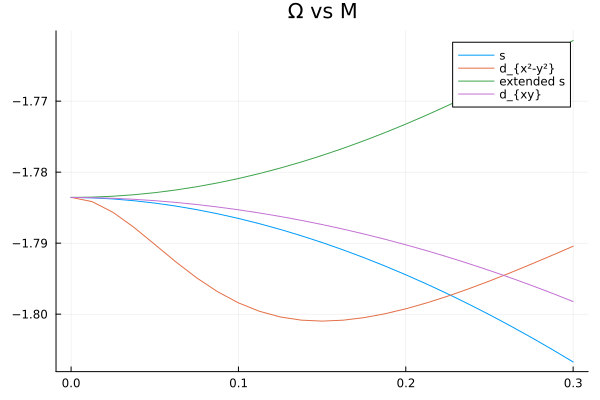

In [20]:
unitcell = Lattice([0, 0]; vectors=[[1, 0], [0, 1]])
cluster = Lattice(unitcell, (2,2), ('p','p'))
hilbert = Hilbert(site=>Fock{:f}(1, 2) for site=1:length(cluster))
bs = BinaryBases(1:4,5:8, 0.0)
t = Hopping(:t, -1.0, 1)
U = Hubbard(:U, 8.0)
μ = Onsite(:μ, -1.2)
coupling=Coupling(Index(:, FID(1, 1//2, 1)), Index(:, FID(1, -1//2, 1)))-Coupling(Index(:, FID(1, -1//2, 1)), Index(:, FID(1, 1//2, 1)))
origiterms = (t, U, μ)
neighbors = Neighbors(0=>0.0, 1=>1.0, 2=>√2)
s = Pairing(:s, 0.3, 0, coupling/2)
dx²y² = Pairing(:dx²y², 0.3, 1, coupling/2; amplitude=phase_by_azimuth([(0,π,2π),(π/2,3π/2)],[1.0,-1.0]))
es = Pairing(:es, 0.3, 1, coupling/2)
dxy = Pairing(:dxy, 0.3, 2, coupling/2; amplitude=phase_by_azimuth([(π/4,5π/4),(3π/4,7π/4)],[1.0, -1.0]))
refertermss = [(t, U, μ, s),(t, U, μ, dx²y²),(t, U, μ, es),(t, U, μ, dxy)]
r = range(1e-9, 0.3, 25)
varparamss = [[(s = a,) for a in r], [(dx²y² = a,) for a in r], [(es = a,) for a in r], [(dxy = a,) for a in r]]
rz = ReciprocalZone(reciprocals(cluster.vectors); length=100)
spawn(16)
@everywhere begin
    include("./supplement.jl")
end 
@time vcas = [pmap(param -> VCA(:A, unitcell, cluster, hilbert, origiterms, refertermss[i], bs, param; neighbors=neighbors, m=200), varparamss[i]) for i in 1:4]
@time gps = [pmap(vca -> GrandPotential(:f, vca, rz, 0.0), vcas[i]) for i in 1:4]

f = plot(range(0, 0.3, 25), gps[1], label="s", legend=:topright, title="Ω vs M")
plot!(range(0, 0.3, 25), gps[2], label="d_{x²-y²}", legend=:topright, title="Ω vs M")
plot!(range(0, 0.3, 25), gps[3], label="extended s", legend=:topright, title="Ω vs M")
plot!(range(0, 0.3, 25), gps[4], label="d_{xy}", legend=:topright, title="Ω vs M")


  2.526141 seconds (2.73 M allocations: 207.517 MiB, 7.89% gc time, 2.16% compilation time)


 57.675316 seconds (1.10 M allocations: 76.332 MiB, 0.23% gc time, 0.10% compilation time)


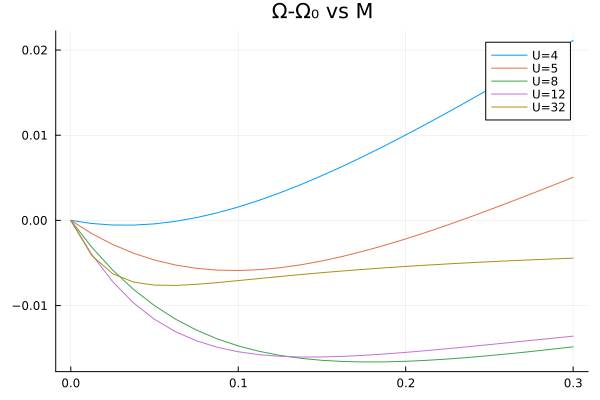

In [7]:

unitcell = Lattice([0, 0]; vectors=[[1, 0],[0, 1]])
cluster = Lattice([0, 0], [1/2, √3/2], [-1/2, √3/2]; vectors=[[3/2, √3/2],[0, √3]])
hilbert = Hilbert(site=>Fock{:f}(1, 2) for site=1:length(cluster))
bs = BinaryBases(6, 3)
t = Hopping(:t, Complex(-1.0), 1)
U = Hubbard(:U, Complex(0.0))
μ = Onsite(:μ, -0.0)
origiterms = (t, U, μ)
t_r = Hopping(:t, Complex(-1.0), 1)
r = Onsite(:r, Complex(0.0),coupling_by_spinrotation(π/2, π/2); amplitude=belongs([1]))
g = Onsite(:g, Complex(0.0),coupling_by_spinrotation(π/2, 7π/6); amplitude=belongs([2]))
b = Onsite(:b, Complex(0.0),coupling_by_spinrotation(π/2, 11π/6); amplitude=belongs([3]))
referterms = (t_r, U, μ, r, g, b)
neighbors = Neighbors(0=>0.0, 1=>1.0)
varparams = [(U = u, r = a, g = a, b = a) for u in [4, 5, 8, 12, 32], a in range(1e-9, 0.3, 25)]
rz = ReciprocalZone(reciprocals(cluster.vectors); length=100)
spawn(3)
@everywhere begin
    include("./supplement.jl")
end 
@time vcas = pmap(param -> VCA(:S, unitcell, cluster, hilbert, origiterms, referterms, bs, param; neighbors=neighbors, m=200), varparams)
@time gps = pmap(vca -> GrandPotential(:f, vca, rz, real(Parameters(vca.refergenerator)[:U]/2)), vcas)

f = plot(range(0, 0.3, 25), gps[1,:].-gps[1,1], label="U=4", legend=:topright, title="Ω-Ω₀ vs M")
plot!(range(0, 0.3, 25), gps[2,:].-gps[2,1], label="U=5", legend=:topright, title="Ω-Ω₀ vs M")
plot!(range(0, 0.3, 25), gps[3,:].-gps[3,1], label="U=8", legend=:topright, title="Ω-Ω₀ vs M")
plot!(range(0, 0.3, 25), gps[4,:].-gps[4,1], label="U=12", legend=:topright, title="Ω-Ω₀ vs M")
plot!(range(0, 0.3, 25), gps[5,:].-gps[5,1], label="U=32", legend=:topright, title="Ω-Ω₀ vs M")

